<a href="https://colab.research.google.com/github/samas-it-services/open-course-delta-lake/blob/feature%2Fblockchain-via-delta-lake/Delta_lake_based_blockchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Blockchain using Delta Lake

This notebook demonstrates the implementation of a blockchain to record financial transactions for a non-profit organization using Delta Lake and PySpark. The blockchain helps ensure data integrity, transparency, and traceability. We also explore anomaly detection to identify suspicious transactions, which may indicate financial fraud.

This example uses PySpark and Delta Lake.


In [1]:
#install required libraries
!pip install -q pyspark
!pip install -q delta-spark
!pip install -q Flask
!pip install -q nest_asyncio
!pip install -q pandas

In [2]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import sha2, concat_ws, col
from delta import configure_spark_with_delta_pip
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

# Initialize Spark session with Delta Lake
builder = SparkSession.builder \
    .appName("BlockchainWithDeltaLake") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Define schema for the blockchain
schema = StructType([
    StructField("index", IntegerType(), False),
    StructField("timestamp", StringType(), False),
    StructField("transactions", StringType(), False),
    StructField("amount", FloatType(), False),
    StructField("previous_hash", StringType(), False),
    StructField("added_by", StringType(), False),
    StructField("category", StringType(), False),
    StructField("description", StringType(), False)
])


# Define a function to create a genesis block
def create_genesis_block():
    data = [(0, "", "", 0.0, "0", "genesis", "education", "Initial block")]
    return spark.createDataFrame(data, schema)

# Define a function to create a new block
def create_block(previous_block, transactions, amount, added_by, category, description):
    new_index = previous_block.select("index").collect()[-1][0] + 1
    timestamp = spark.sql("SELECT current_timestamp()").collect()[0][0].isoformat()
    previous_hash = previous_block.select("hash").collect()[-1][0]
    block_data = [(new_index, timestamp, transactions, amount, previous_hash, added_by, category, description)]
    return spark.createDataFrame(block_data, schema)

# Define a function to calculate hash of a block
def calculate_hash(block_df):
    block_df = block_df.withColumn("hash", sha2(concat_ws("||", col("index"), col("timestamp"), col("transactions"), col("amount"), col("previous_hash"), col("added_by"), col("category"), col("description")), 256))
    return block_df

# Create genesis block
genesis_block = create_genesis_block()
genesis_block = calculate_hash(genesis_block)

# Save genesis block to Delta Lake
genesis_block.write.format("delta").mode("overwrite").save("/tmp/delta/blockchain")

# Sample financial transactions with realistic data
transactions = [
    {"transactions": "Payment for school fees", "amount": 5000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Fee payment for Sawaira Sajjad of class 11"},
    {"transactions": "Purchase of books and uniform", "amount": 2000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Books and uniform for Sawaira Sajjad of class 11"},
    {"transactions": "Payment for admission fee", "amount": 6000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Admission fee for Malaika Khan of class 10"},
    {"transactions": "Payment for school fees", "amount": 7000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Fee payment for Ali Khan of class 12 in medical"},
    {"transactions": "Purchase of books", "amount": 3000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Books for Ali Khan of class 12 in medical"},
    {"transactions": "Payment for school fees", "amount": 4000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Fee payment for Saiqa Khan of class 8"},
    {"transactions": "Purchase of books and uniform", "amount": 1500.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Books and uniform for Saiqa Khan of class 8"},
    {"transactions": "Payment for school fees", "amount": 4000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Fee payment for Usman Sajjad of class 8"},
    {"transactions": "Purchase of books and uniform", "amount": 1500.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Books and uniform for Usman Sajjad of class 8"}
]

# Create and add new blocks
previous_block = genesis_block
for txn in transactions:
    new_block = create_block(previous_block, txn["transactions"], txn["amount"], txn["added_by"], txn["category"], txn["description"])
    new_block = calculate_hash(new_block)
    new_block.write.format("delta").mode("append").save("/tmp/delta/blockchain")
    previous_block = new_block

# Read and display the blockchain
blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
blockchain_df.orderBy("index").show(truncate=False)

+-----+--------------------------+-----------------------------+------+----------------------------------------------------------------+-------------+---------+------------------------------------------------+----------------------------------------------------------------+
|index|timestamp                 |transactions                 |amount|previous_hash                                                   |added_by     |category |description                                     |hash                                                            |
+-----+--------------------------+-----------------------------+------+----------------------------------------------------------------+-------------+---------+------------------------------------------------+----------------------------------------------------------------+
|0    |                          |                             |0.0   |0                                                               |genesis      |education|Initial block  

In [3]:
# Import required libraries
from flask import Flask, request, jsonify
from pyspark.sql import SparkSession
from pyspark.sql.functions import sha2, concat_ws, col
from delta import configure_spark_with_delta_pip
import nest_asyncio
from threading import Thread

# Initialize Spark session with Delta Lake
builder = SparkSession.builder \
    .appName("BlockchainWithDeltaLake") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Flask application setup
app = Flask(__name__)

# API endpoint to add a new block
@app.route('/add_block', methods=['POST'])
def add_block():
    previous_block = spark.read.format("delta").load("/tmp/delta/blockchain").orderBy("index", ascending=False).limit(1)
    transactions = request.json.get('transactions')
    amount = request.json.get('amount')
    added_by = request.json.get('added_by')
    category = request.json.get('category')
    description = request.json.get('description')

    new_block = create_block(previous_block, transactions, amount, added_by, category, description)
    new_block = calculate_hash(new_block)
    new_block.write.format("delta").mode("append").save("/tmp/delta/blockchain")

    return jsonify({"message": "Block added successfully"}), 201

# API endpoint to get the blockchain
@app.route('/get_blockchain', methods=['GET'])
def get_blockchain():
    blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
    blockchain_list = blockchain_df.collect()
    blockchain_json = [row.asDict() for row in blockchain_list]

    return jsonify(blockchain_json), 200

# Ensure the notebook can handle Flask requests
nest_asyncio.apply()

# This code will start the Flask app in a background thread
def start_app():
    app.run(port=5001)

thread = Thread(target=start_app)
thread.start()


 # add the financial transactions via API
 We'll use the Flask API endpoints to add these transactions.

In [4]:
# Add sample transactions
import requests

# API URL
api_url = "http://localhost:5001/add_block"

# Sample financial transactions with realistic data
transactions = [
    # Additional diverse transactions
    {"transactions": "Purchase of sports equipment", "amount": 2500.0, "added_by": "Syed Bilgrami", "category": "extracurricular", "description": "Sports equipment for school"},
    {"transactions": "Transportation fees", "amount": 3000.0, "added_by": "Syed Bilgrami", "category": "transportation", "description": "Monthly bus pass for Sawaira Sajjad"},
    {"transactions": "Purchase of lab supplies", "amount": 4500.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Lab supplies for Ali Khan's medical studies"},
    {"transactions": "Field trip expenses", "amount": 3500.0, "added_by": "Syed Bilgrami", "category": "extracurricular", "description": "Field trip expenses for Malaika Khan"},
    {"transactions": "After-school program", "amount": 2000.0, "added_by": "Syed Bilgrami", "category": "extracurricular", "description": "Fee for after-school program for Usman Sajjad"}
]
# Add transactions using the API
for transaction in transactions:
    response = requests.post(api_url, json=transaction)
    print(response.json())

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [24/Jun/2024 00:30:11] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [24/Jun/2024 00:30:32] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [24/Jun/2024 00:30:47] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [24/Jun/2024 00:30:57] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [24/Jun/2024 00:31:07] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


In [21]:
import ipywidgets as widgets
from IPython.display import display, Markdown
import requests
# Display the summary in Markdown
display(Markdown("""
# Transaction Entry Form

Use this form to enter transactions for a non-profit organization in education that pays for school fee expenses.
Please fill in all the required fields and click "Submit" to add the transaction.

### Required Fields
- **Transactions**: Description of the transaction (e.g., "Fee payment for student X")
- **Amount**: Amount of the transaction
- **Added By**: Your name
- **Category**: Select a category from the dropdown (e.g., education, books, uniform, extracurricular, transportation, admission)

### Optional Field
- **Description**: Additional description for the transaction
"""))

# API URL
api_url = "http://localhost:5001/add_block"

# Create form fields
transactions_input = widgets.Text(description="Transactions:", placeholder="Enter transaction description")
amount_input = widgets.FloatText(description="Amount:", placeholder="Enter amount")
added_by_input = widgets.Text(description="Added By:", placeholder="Enter your name")
category_input = widgets.Dropdown(
    options=["education", "books", "uniform", "extracurricular", "transportation", "admission", "other"],
    description="Category:",
    value=None
)
description_input = widgets.Text(description="Description:", placeholder="Enter optional description")
submit_button = widgets.Button(description="Submit")

# Function to handle form submission
def submit_transaction(b):
    if not transactions_input.value or not amount_input.value or not added_by_input.value or not category_input.value:
        print("Please fill in all required fields.")
        return

    transaction_data = {
        "transactions": transactions_input.value,
        "amount": amount_input.value,
        "added_by": added_by_input.value,
        "category": category_input.value,
        "description": description_input.value
    }

    response = requests.post(api_url, json=transaction_data)

    if response.status_code == 201:
        print("Transaction added successfully!")
    else:
        print("Failed to add transaction. Status code:", response.status_code)

# Attach the submit function to the button
submit_button.on_click(submit_transaction)

# Display the form
display(transactions_input, amount_input, added_by_input, category_input, description_input, submit_button)



# Transaction Entry Form

Use this form to enter transactions for a non-profit organization in education that pays for school fee expenses. 
Please fill in all the required fields and click "Submit" to add the transaction.

### Required Fields
- **Transactions**: Description of the transaction (e.g., "Fee payment for student X")
- **Amount**: Amount of the transaction
- **Added By**: Your name
- **Category**: Select a category from the dropdown (e.g., education, books, uniform, extracurricular, transportation, admission)

### Optional Field
- **Description**: Additional description for the transaction


Text(value='', description='Transactions:', placeholder='Enter transaction description')

FloatText(value=0.0, description='Amount:')

Text(value='', description='Added By:', placeholder='Enter your name')

Dropdown(description='Category:', options=('education', 'books', 'uniform', 'extracurricular', 'transportation…

Text(value='', description='Description:', placeholder='Enter optional description')

Button(description='Submit', style=ButtonStyle())

INFO:werkzeug:127.0.0.1 - - [24/Jun/2024 01:11:49] "POST /add_block HTTP/1.1" 201 -


Transaction added successfully!


# Display the financial transactions in the blockchain

In [22]:
# Read and display the blockchain
blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
blockchain_df.orderBy("index").show(truncate=False)

+-----+--------------------------+-----------------------------------+--------+----------------------------------------------------------------+-------------+---------------+-----------------------------------------------------------------------+----------------------------------------------------------------+
|index|timestamp                 |transactions                       |amount  |previous_hash                                                   |added_by     |category       |description                                                            |hash                                                            |
+-----+--------------------------+-----------------------------------+--------+----------------------------------------------------------------+-------------+---------------+-----------------------------------------------------------------------+----------------------------------------------------------------+
|0    |                          |                              

# Visualizing the Financial Budget
Visualize the financial budget for the current quarter and the current year, and then project it for the next three quarters and the next two years, we can use the data from the blockchain. Let's proceed step by step:

- Read the blockchain data from Delta Lake.
- Aggregate the data to calculate the financial budget for the current quarter and year.
- Project the financial budget for the next three quarters and the next two years.
- Visualize the financial budget using Matplotlib

## Step 1: Read the blockchain data from Delta Lake


In [6]:
# Step 1: Read the blockchain data from Delta Lake
import pandas as pd
# Read the blockchain ordered by index
blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
ordered_blockchain_df = blockchain_df.orderBy("index")

# Convert to Pandas DataFrame for easier manipulation
blockchain_pd_df = ordered_blockchain_df.toPandas()

# Convert timestamp to datetime
blockchain_pd_df['timestamp'] = pd.to_datetime(blockchain_pd_df['timestamp'])


## Step 2: Aggregate the data


In [7]:
# Step 2: Aggregate the data
import pandas as pd

# Group by quarter and year to get the financial budget
blockchain_pd_df['quarter'] = blockchain_pd_df['timestamp'].dt.to_period('Q')
blockchain_pd_df['year'] = blockchain_pd_df['timestamp'].dt.year

# Aggregate the data by quarter and year
quarterly_budget = blockchain_pd_df.groupby('quarter')['amount'].sum().reset_index()
yearly_budget = blockchain_pd_df.groupby('year')['amount'].sum().reset_index()


## Step 3: Project the financial budget
Now, let's retrieve the data from the blockchain and visualize the financial budget.

In [8]:
# Step 3: Project the financial budget

# Get the current quarter and year
current_quarter = pd.Period(pd.Timestamp.now(), freq='Q')
current_year = pd.Timestamp.now().year

# Calculate the average budget per quarter for projection
average_quarterly_budget = quarterly_budget['amount'].mean()

# Project for the next three quarters and next two years
projection_quarters = [current_quarter + i for i in range(1, 4)]
projection_years = [current_year + i for i in range(1, 3)]

# Create DataFrame for the projected quarters
projection_quarterly_df = pd.DataFrame({
    'quarter': projection_quarters,
    'amount': [average_quarterly_budget] * 3
})

# Create DataFrame for the projected years
average_yearly_budget = yearly_budget['amount'].mean()
projection_yearly_df = pd.DataFrame({
    'year': projection_years,
    'amount': [average_yearly_budget] * 2
})


## Step 4: Visualize the financial budget


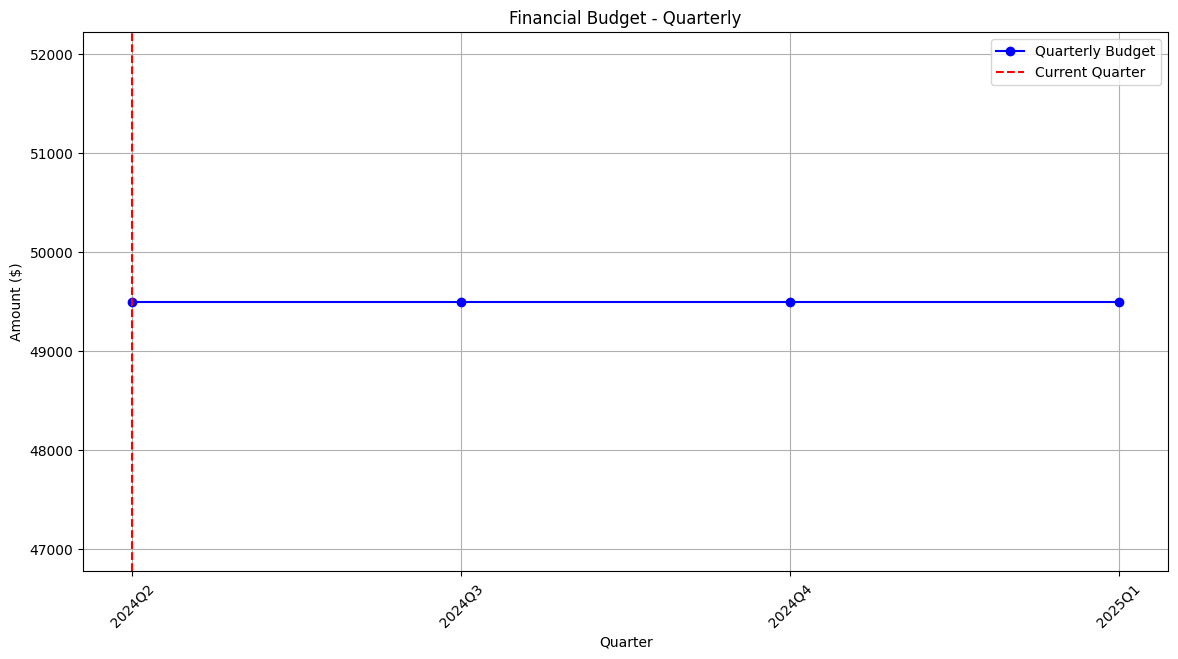

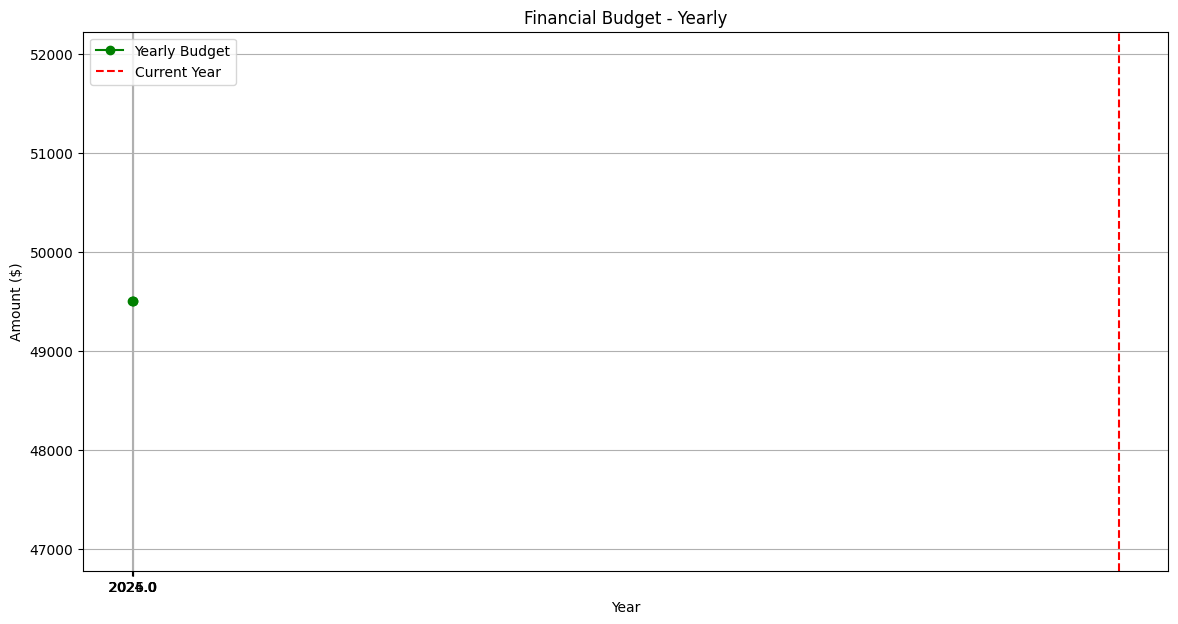

In [9]:
import matplotlib.pyplot as plt

# Combine actual and projected budgets
combined_quarterly_budget = pd.concat([quarterly_budget, projection_quarterly_df]).reset_index(drop=True)
combined_yearly_budget = pd.concat([yearly_budget, projection_yearly_df]).reset_index(drop=True)

# Plot the quarterly budget
plt.figure(figsize=(14, 7))
plt.plot(combined_quarterly_budget['quarter'].astype(str), combined_quarterly_budget['amount'], marker='o', linestyle='-', color='b', label='Quarterly Budget')
plt.axvline(x=str(current_quarter), color='r', linestyle='--', label='Current Quarter')
plt.title('Financial Budget - Quarterly')
plt.xlabel('Quarter')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Plot the yearly budget
plt.figure(figsize=(14, 7))
plt.plot(combined_yearly_budget['year'].astype(str), combined_yearly_budget['amount'], marker='o', linestyle='-', color='g', label='Yearly Budget')
plt.axvline(x=current_year, color='r', linestyle='--', label='Current Year')
plt.title('Financial Budget - Yearly')
plt.xlabel('Year')
plt.ylabel('Amount ($)')
plt.legend()
plt.grid(True)
plt.show()


# Verify blockchain integrity and Detect anomalies

## Principle Used to Detect Anomaly

In the context of this example, anomaly detection is based on statistical methods, specifically the Z-score method. The Z-score measures how many standard deviations a data point is from the mean of the data set. Here’s a breakdown of the process:

1. **Calculate Mean and Standard Deviation**: Determine the average transaction amount and the standard deviation of the transaction amounts.
2. **Compute Z-Score**: For each transaction, calculate the Z-score using the formula:

  ![Z-score Equation](https://www.gstatic.com/education/formulas2/553212783/en/z_score.svg)

where \(X\) is the transaction amount, (μ) is the mean transaction amount, and (σ) is the standard deviation.

3. **Identify Anomalies**: Transactions with a Z-score greater than 3 or less than -3 are considered anomalies. This threshold is based on the empirical rule (68-95-99.7 rule), where nearly all data points lie within three standard deviations of the mean in a normal distribution.





## Read the blockchain ordered by index


In [10]:
# Read the blockchain ordered by index
blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
ordered_blockchain_df = blockchain_df.orderBy("index")


In [11]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Window

def verify_blockchain(df):
    # Create a window specification to access the previous row's hash
    window_spec = Window.orderBy("index")

    # Calculate the hash of each row
    df = df.withColumn(
        "calculated_hash",
        sha2(
            concat_ws(
                "||",
                col("index"),
                col("timestamp"),
                col("transactions"),
                col("amount"),
                col("previous_hash"),
                col("added_by"),
                col("category"),
                col("description")
            ),
            256
        )
    )

    # Check for integrity issues by comparing the previous hash and calculated hash
    df = df.withColumn(
        "previous_hash_check",
        F.lag("hash").over(window_spec)
    ).withColumn(
        "integrity_issue",
        (F.col("previous_hash") != F.col("previous_hash_check")) | (F.col("hash") != F.col("calculated_hash"))
    )

    # Filter rows with integrity issues
    integrity_issues = df.filter(F.col("integrity_issue"))

    return integrity_issues

integrity_issues_df = verify_blockchain(ordered_blockchain_df)
integrity_issues_df.show(truncate=False)

if integrity_issues_df.count() > 0:
    print("Integrity issues found.")
else:
    print("No integrity issues found.")


+-----+---------+------------+------+-------------+--------+--------+-----------+----+---------------+-------------------+---------------+
|index|timestamp|transactions|amount|previous_hash|added_by|category|description|hash|calculated_hash|previous_hash_check|integrity_issue|
+-----+---------+------------+------+-------------+--------+--------+-----------+----+---------------+-------------------+---------------+
+-----+---------+------------+------+-------------+--------+--------+-----------+----+---------------+-------------------+---------------+

No integrity issues found.


 # Visualize the anomalies

We simulate adding some fraudulent data to the blockchain that contains higher than usual amounts. We'll then use anomaly detection to identify the suspicious transactions and project the correct data for Q2 and Q3.

In [12]:
import requests

# API URL
api_url = "http://localhost:5001/add_block"

# Sample fraudulent transactions
fraudulent_transactions = [
    {"transactions": "Fee payment for John Doe of class 9", "amount": 150000.0, "added_by": "Bad Actor", "category": "extracurricular", "description": "Fee for after-school program for Sawaira Sajjad"},
    {"transactions": "Late-night-entertainment program", "amount": 50000.0, "added_by": "Bad Actor", "category": "extracurricular", "description": "Fee for after-school program for Malaika Khan"}
]

# Add fraudulent transactions using the API
for transaction in fraudulent_transactions:
    response = requests.post(api_url, json=transaction)
    print(response.json())


INFO:werkzeug:127.0.0.1 - - [24/Jun/2024 00:33:57] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [24/Jun/2024 00:34:08] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


Next, let's retrieve the blockchain data, detect anomalies, and visualize the results.



In [23]:
"""
Detect anomalies in the transactions using Z-score.
Once a transaction by a bad actor is identified, print potential anomalies by identifying other transactions from the same `added_by`.
Also, print a summary of the count of anomalies and potential anomalies, grouped by `added_by` within the month and year of the transaction.
"""

# Detect anomalies in the transactions
def detect_anomalies(df):
    # Calculate mean and standard deviation of the amount column
    stats = df.select(
        F.mean("amount").alias("mean_amount"),
        F.stddev("amount").alias("std_amount")
    ).collect()[0]

    mean_amount = stats["mean_amount"]
    std_amount = stats["std_amount"]

    # Calculate Z-score for each transaction
    df = df.withColumn(
        "z_score",
        (F.col("amount") - mean_amount) / std_amount
    )

    # Filter rows where Z-score is greater than 3 or less than -3
    anomalies = df.filter((F.col("z_score") > 3) | (F.col("z_score") < -3))

    return anomalies

# Call the function to detect anomalies
anomalies_df = detect_anomalies(ordered_blockchain_df)

# Check if any anomalies were detected
if anomalies_df.count() > 0:
    print("Anomalies detected.")
    # Identify other transactions from the same `added_by` as the anomalies
    bad_actor_ids = anomalies_df.select("added_by").distinct()
    potential_anomalies_df = ordered_blockchain_df.join(bad_actor_ids, on="added_by", how="inner").orderBy("index")

    # Print summary
    anomaly_count = anomalies_df.count()
    potential_anomaly_count = potential_anomalies_df.count()

    print(f"Count of anomalies: {anomaly_count}")
    print(f"Count of potential anomalies: {potential_anomaly_count}")

    # Group by `added_by` and show count within month and year of transaction
    summary_df = potential_anomalies_df.withColumn("month", F.month("timestamp")).withColumn("year", F.year("timestamp")) \
                                       .groupBy("added_by", "month", "year") \
                                       .agg(F.count("amount").alias("count"))

    print(f"Summary of anomalies")
    summary_df.show(truncate=False)

    print(f"anomalies: Total {anomalies_df.count()}")
    anomalies_df.show(truncate=False)

    # Show potential anomalies
    print(f"Potential anomalies: Total {potential_anomalies_df.count()}")
    potential_anomalies_df.show(truncate=False)


else:
    print("No anomalies detected.")


Anomalies detected.
Count of anomalies: 1
Count of potential anomalies: 2
Summary of anomalies
+---------+-----+----+-----+
|added_by |month|year|count|
+---------+-----+----+-----+
|Bad Actor|6    |2024|2    |
+---------+-----+----+-----+

anomalies: Total 1
+-----+--------------------------+-----------------------------------+--------+----------------------------------------------------------------+---------+---------------+-----------------------------------------------+----------------------------------------------------------------+-----------------+
|index|timestamp                 |transactions                       |amount  |previous_hash                                                   |added_by |category       |description                                    |hash                                                            |z_score          |
+-----+--------------------------+-----------------------------------+--------+---------------------------------------------------------


# How Blockchain Helped

The blockchain’s inherent properties enhance the anomaly detection process:

- **Immutability**: Once a transaction is recorded in a blockchain, it cannot be altered or deleted. This ensures the integrity and reliability of the transaction history, making it easier to trust the data used for anomaly detection.
- **Transparency**: Every transaction is recorded in a public or permissioned ledger, which allows for complete transparency. This makes it easier to audit transactions and spot any suspicious activity.
- **Traceability**: Blockchain records the entire history of transactions, which helps in tracking and verifying the origin and flow of transactions.

# Delta Lake vs. Ethereum-Based Blockchain

## Delta Lake Blockchain

**Pros**:

- **Performance**: Delta Lake, built on top of Apache Spark, offers high performance for big data analytics and can handle large volumes of data efficiently.
- **Cost-Effective**: Running Delta Lake on existing infrastructure (e.g., on-premises or cloud storage) can be more cost-effective than using a public blockchain network.
- **Flexibility**: Delta Lake integrates well with various big data tools and frameworks, providing flexibility in data processing and analytics.
- **Scalability**: Delta Lake can scale horizontally to handle increasing data loads, making it suitable for large datasets.

**Cons**:

- **Centralization**: Unlike public blockchains, Delta Lake is typically deployed in a centralized or semi-centralized environment, which may not provide the same level of decentralization and trustlessness.
- **Security**: Being centralized or semi-centralized, it may be more susceptible to single points of failure or attacks compared to a decentralized blockchain.
- **Limited Smart Contracts**: Delta Lake does not inherently support smart contracts, which limits its use cases compared to Ethereum.

## Ethereum-Based Blockchain

**Pros**:

- **Decentralization**: Ethereum is a decentralized blockchain network, which means no single entity controls the network, enhancing security and trust.
- **Smart Contracts**: Ethereum supports smart contracts, which are self-executing contracts with the terms of the agreement directly written into code. This enables complex, automated interactions between parties.
- **Security**: Ethereum's consensus mechanisms (e.g., Proof of Stake) and decentralization enhance security against attacks.
- **Transparency and Immutability**: Ethereum provides high transparency and immutability, which is critical for applications requiring trust and auditability.

**Cons**:

- **Cost**: Transactions on Ethereum require gas fees, which can be expensive, especially during network congestion.
- **Performance**: Ethereum's transaction throughput is limited compared to traditional databases and big data systems, potentially leading to slower transaction times.
- **Scalability**: Despite ongoing improvements, Ethereum faces scalability challenges, making it less suitable for applications requiring high transaction volumes.

# Conclusion

The choice between a Delta Lake-based blockchain and an Ethereum-based blockchain depends on the specific use case requirements. Delta Lake may be more suitable for applications focused on large-scale data analytics and cost-efficiency, while Ethereum provides robust decentralization, security, and smart contract capabilities for applications requiring high trust and automation.